## <font color='Blue'>Introduction</font>
###  In the practical, we run the example model for evaluation of permebaility field.

## <font color='blue'>The objectives:</font>
1. Introduce custom <font color='red'>'Model'</font> class based on 
 * Class [DartsModel](./darts/models/darts_model.py) with base model capabilities
 * Class [StructReservoir](./darts/models/reservoirs/struct_reservoir.py) with structured reservoir
 * Class [Deadoil](./darts/models/physics/dead_oil_python.py) for basic dead oil physics
 * Class [Deadoil-properties](./darts/models/physics/do_properties_python.py) for dead oil properties, such as density, viscosity and relative permeability
2. Use run_python procedure to control run from the python script
3. Introduce wells and time-dependent well controls
4. Redefine physical properties and run simulation with custom-defined property.

## <font color='Blue'>Let's start!</font>


In [1]:
from darts.models.reservoirs.struct_reservoir import StructReservoir
from darts.models.physics.dead_oil_python import DeadOil
from darts.models.darts_model import DartsModel
from darts.engines import value_vector
from darts.tools.keyword_file_tools import load_single_keyword

import numpy as np
import matplotlib.pyplot as plt

#### Brief Introduction of model inheritance
* Here create the <font color='red'>'Model' </font>  class, which inherits from <font color='red'>DartsModel</font> (the base class).
* It keeps all the functionalities of <font color='red'>DartsModel</font> and can also be extended to add more functionalities.
* If a function is redefined in subclass, the function in base class with identical name will be overridden.

In [2]:
class Model(DartsModel):
    def __init__(self, perm=None, nd = 60, db = 8):
        # call base class constructor
        super().__init__()

        # measure time spend on reading/initialization
        self.timer.node["initialization"].start()

        # create reservoir
        self.nx = nd
        self.ny = nd
        self.nz = 1
        
        self.dx = db
        self.dy = db
        self.dz = 4

        if (perm is None):
            perm = np.ones(self.nx*self.ny)*3000
        else:
            perm = perm.reshape(self.nx*self.ny)
            
        self.permx = perm
        self.permy = perm
        self.permz = 0.1 * perm
        self.poro = 0.2
        self.depth = 4000

        # run discretization
        self.reservoir = StructReservoir(self.timer, nx=self.nx, ny=self.ny, nz=self.nz, dx=self.dx, dy=self.dy,
                                         dz=self.dz, permx=self.permx, permy=self.permy, permz=self.permz,
                                         poro=self.poro, depth=self.depth)

        self.ix = np.int32(self.nx / 2)
        self.iy = np.int32(self.ny / 2)
        
        self.reservoir.add_well("INJ1")
        self.reservoir.add_perforation(self.reservoir.wells[-1], self.ix, self.iy, 1,  well_index=10)

        # Production wells
        self.reservoir.add_well("PRD1")
        self.reservoir.add_perforation(self.reservoir.wells[-1], self.nx, self.ny, 1, well_index=10)
        
        self.reservoir.add_well("PRD2")
        self.reservoir.add_perforation(self.reservoir.wells[-1], 1, self.ny, 1, well_index=10)
        
        self.reservoir.add_well("PRD3")
        self.reservoir.add_perforation(self.reservoir.wells[-1], self.nx, 1, 1, well_index=10)
        
        self.reservoir.add_well("PRD4")
        self.reservoir.add_perforation(self.reservoir.wells[-1], 1, 1, 1, well_index=10)
        
        
        # create physics
        self.physics = DeadOil(timer=self.timer, physics_filename='physics.in',
                               n_points=401, min_p=300, max_p=600, min_z=1e-8)

        self.params.first_ts = 1
        self.params.mult_ts = 2
        self.params.max_ts = 50
        self.params.tolerance_newton = 1e-2
        self.params.tolerance_linear = 1e-3

        self.inj = [1]

        self.runtime = 1000

        self.timer.node["initialization"].stop()

    def set_initial_conditions(self):
        self.physics.set_uniform_initial_conditions(self.reservoir.mesh, uniform_pressure=400,
                                                    uniform_composition=[0.1])

    def set_boundary_conditions(self):
        for i, w in enumerate(self.reservoir.wells):
            if w.name[:3] == "INJ":
                w.control = self.physics.new_bhp_water_inj(410, self.inj)
                # w.constraint = self.physics.new_rate_water_prod(210)
            else:
                w.control = self.physics.new_bhp_prod(390)

    # This function plots streamlines based on passed pressure solution 
    # and permebility map from model class
    def plot_streamline(self, p, array, col='r'):

        P_2D = p.reshape(self.nx, self.ny)
        kx = self.permx.reshape(self.ny, self.nx)
        ky = self.permy.reshape(self.ny, self.nx)
        nvx, nvy = (self.nx-1, self.ny-1)

        v = np.zeros((nvx, nvy))
        u = np.zeros((nvx, nvy))
        ir, jr = (range(nvx), range(nvy))

        for i in ir:
            v[i, jr] = (kx[i, jr] + kx[i + 1, jr]) * (P_2D[i, jr] - P_2D[i + 1, jr])
        for j in jr:
            u[ir, j] = (ky[ir, j] + ky[ir, j + 1]) * (P_2D[ir, j] - P_2D[ir, j + 1])

        # find circle in 2D index array with radius r
        x = np.arange(0, nvx)
        y = np.arange(0, nvy)
        arr = np.zeros((nvx,nvy))
        r = 6. # make sure that the model is larger than [2r] * [2r]
        arr[(x[np.newaxis, :] - self.ix) ** 2 + (y[:, np.newaxis] - self.iy) ** 2 < r ** 2] = 1
        arr[(x[np.newaxis, :] - self.ix) ** 2 + (y[:, np.newaxis] - self.iy) ** 2 < (r-1) ** 2] = 0

        # starting points for streamlines
        sp = np.array(np.where(arr == 1))
        y, x = np.mgrid[1:nvy+1, 1:nvx+1]
        cont = plt.streamplot(x, y, u, v, density=100, color=col, linewidth=1, cmap='autumn', start_points=sp.T)

        array=array.reshape(self.ny, self.nx)
        plt.pcolor(array)

<img style="float: left;" src="slides/Slide7.JPG" width="80%">

In [3]:
# Permeability data
perm = load_single_keyword('data.in','PERMX') #specify the name of the file and the k word


# Model
m = Model(perm)
m.init()
m.run()
print("Simulation finished")

Reading PERMX from /home/jovyan/data.in... 3600 values have been read.
darts-package built on 08/10/2020 18:32:54 by root@runner-Gd7HMPkj-project-1205-concurrent-0 from 180bd2c
Building connection list...
Simulation finished


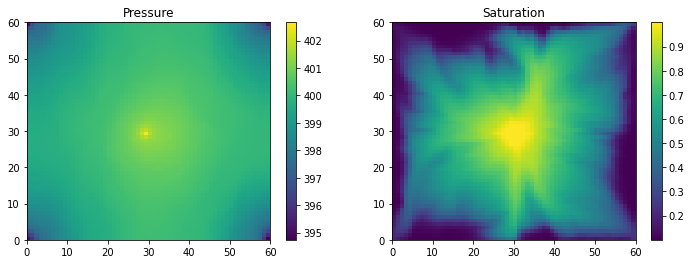

In [4]:
# process active grid
X  = np.array(m.physics.engine.X, copy=False)
nb = m.nx * m.ny

p  = X[0:2*nb:2] 
z  = X[1:2*nb:2] 

# plot solution
plt.figure(num=1, figsize=(12,4))
plt.subplot(121)
plt.pcolor(p.reshape(m.ny, m.nx))
plt.title('Pressure')
plt.colorbar()

# plot solution
plt.subplot(122)
plt.pcolor(z.reshape(m.ny, m.nx))
plt.title('Saturation')
plt.colorbar()
plt.show()

<img style="float: left;" src="slides/Slide8.JPG" width="80%">

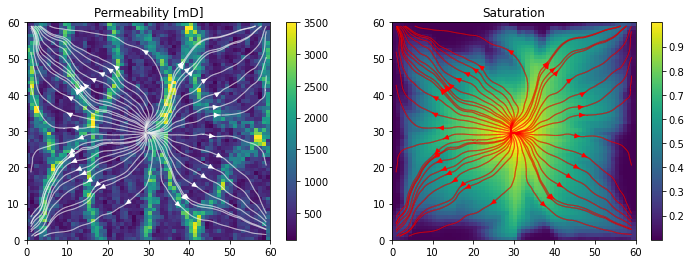

In [5]:
plt.figure(num=1, figsize=(12,4))
plt.subplot(121)
m.plot_streamline(p,m.permx,col='w')
plt.colorbar()
plt.title('Permeability [mD]')

plt.subplot(122)
m.plot_streamline(p,z,col='r')
plt.title('Saturation')
plt.colorbar()
plt.show()

<img style="float: left;" src="slides/Slide9.JPG" width="80%">

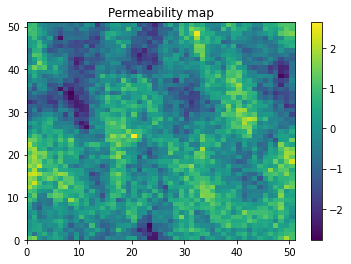

In [7]:
from scipy.io import loadmat 
data = loadmat('model_1.mat')
realiz = np.array(data['realz'])

plt.figure()
plt.pcolor(realiz)
plt.colorbar()
plt.title('Permeability map')
plt.show()

<img style="float: left;" src="slides/Slide10.JPG" width="80%">

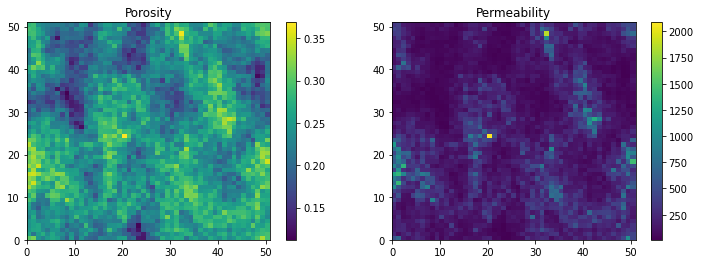

(3600,)

In [8]:
sp_mean = 0.24
m_r = np.mean(realiz)       # Mean
sigma = 0.04
sigma_r = np.std(realiz)    # Standard deviation

phi = sp_mean-m_r*sigma/sigma_r+realiz*sigma/sigma_r  # Equation above

plt.figure(num=1, figsize=(12,4))
plt.subplot(121)
plt.pcolor(phi)
plt.title('Porosity')
plt.colorbar()

permeab = 10**(9*phi)          # Permeability with typical correlation

# plot solution
plt.subplot(122)
plt.pcolor(permeab)
plt.title('Permeability')
plt.colorbar()
plt.show()

np.shape(perm)

<img style="float: left;" src="slides/Slide11.JPG" width="80%">

In [9]:
m = Model(permeab,51)
m.init()
m.run()
print("Simulation finished")

darts-package built on 08/10/2020 18:32:54 by root@runner-Gd7HMPkj-project-1205-concurrent-0 from 180bd2c
Building connection list...
Simulation finished


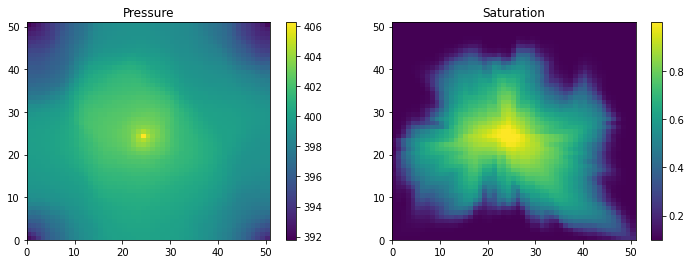

In [10]:
# process active grid
X  = np.array(m.physics.engine.X, copy=False)
nb = m.nx * m.ny

p  = X[0:2*nb:2] 
z  = X[1:2*nb:2] 

# plot solution
plt.figure(num=1, figsize=(12,4))
plt.subplot(121)
plt.pcolor(p.reshape(m.ny, m.nx))
plt.title('Pressure')
plt.colorbar()

# plot solution
plt.subplot(122)
plt.pcolor(z.reshape(m.ny, m.nx))
plt.title('Saturation')
plt.colorbar()
plt.show()

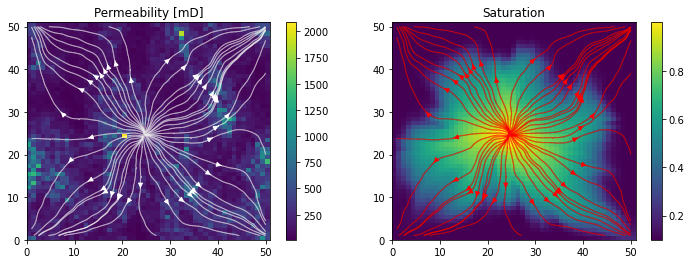

In [11]:
plt.figure(num=1, figsize=(12,4))
plt.subplot(121)
m.plot_streamline(p,m.permx,col='w')
plt.colorbar()
plt.title('Permeability [mD]')

plt.subplot(122)
m.plot_streamline(p,z,col='r')
plt.title('Saturation')
plt.colorbar()
plt.show()

<img style="float: left;" src="slides/Slide12.JPG" width="80%">

# 1. Own model

In [12]:
from scipy.io import loadmat 
data = loadmat('assig5_model.mat')
realiz = np.array(data['realz'])

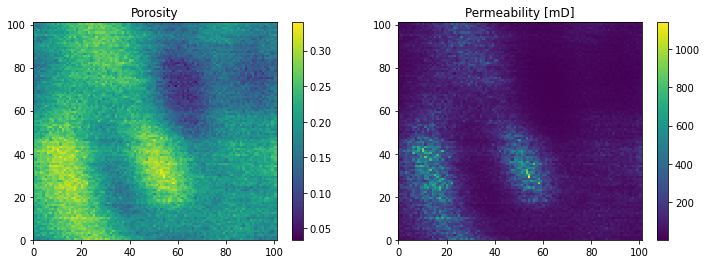

In [13]:
sp_m = 0.2
mr = np.mean(realiz)
sigma = 0.05
sigmar = np.std(realiz)

phi = sp_m-mr*sigma/sigmar+realiz*sigma/sigmar

plt.figure(num=1, figsize=(12,4))
plt.subplot(121)
plt.pcolor(phi)
plt.title('Porosity')
plt.colorbar()

perm = 10**(9*phi)

# plot solution
plt.subplot(122)
plt.pcolor(perm)
plt.title('Permeability [mD]')
plt.colorbar()
plt.show()

# 2. After breakthrough

In [14]:
m = Model(perm, 101)
m.init()
m.run(50000)
print("Simulation finished")

darts-package built on 08/10/2020 18:32:54 by root@runner-Gd7HMPkj-project-1205-concurrent-0 from 180bd2c
Building connection list...
Simulation finished


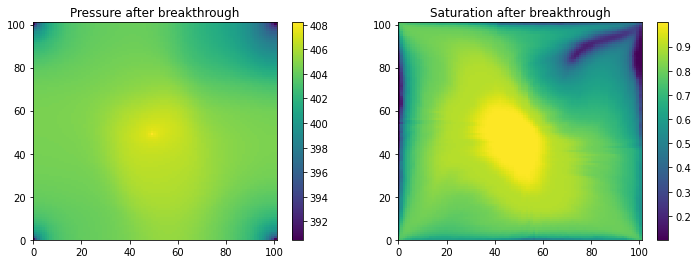

In [16]:
# process active grid
X  = np.array(m.physics.engine.X, copy=False)
nb = m.nx * m.ny

p  = X[0:2*nb:2] 
z  = X[1:2*nb:2] 

# plot solution
plt.figure(num=1, figsize=(12,4))
plt.subplot(121)
plt.pcolor(p.reshape(m.ny, m.nx))
plt.title('Pressure after breakthrough')
plt.colorbar()

# plot solution
plt.subplot(122)
plt.pcolor(z.reshape(m.ny, m.nx))
plt.title('Saturation after breakthrough')
plt.colorbar()
plt.show()

#### Streamlines

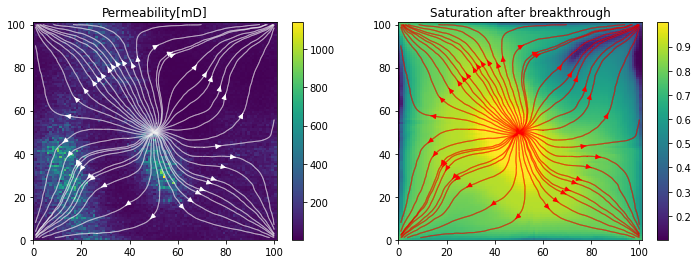

In [17]:
plt.figure(num=1, figsize=(12,4))
plt.subplot(121)
m.plot_streamline(p,m.permx,col='w')
plt.colorbar()
plt.title('Permeability[mD]')

plt.subplot(122)
m.plot_streamline(p,z,col='r')
plt.title('Saturation after breakthrough')
plt.colorbar()
plt.show()

# 3. Before breaktrhough

In [18]:
m = Model(perm, 101)
m.init()
m.run(500)
print("Simulation finished")

darts-package built on 08/10/2020 18:32:54 by root@runner-Gd7HMPkj-project-1205-concurrent-0 from 180bd2c
Building connection list...
Simulation finished


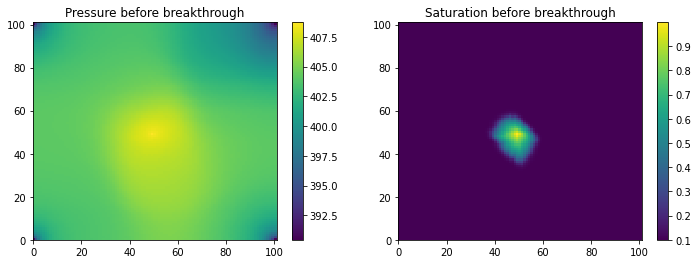

In [19]:
# process active grid
X  = np.array(m.physics.engine.X, copy=False)
nb = m.nx * m.ny

p  = X[0:2*nb:2] 
z  = X[1:2*nb:2] 

# plot solution
plt.figure(num=1, figsize=(12,4))
plt.subplot(121)
plt.pcolor(p.reshape(m.ny, m.nx))
plt.title('Pressure before breakthrough')
plt.colorbar()

# plot solution
plt.subplot(122)
plt.pcolor(z.reshape(m.ny, m.nx))
plt.title('Saturation before breakthrough')
plt.colorbar()
plt.show()

#### Streamlines

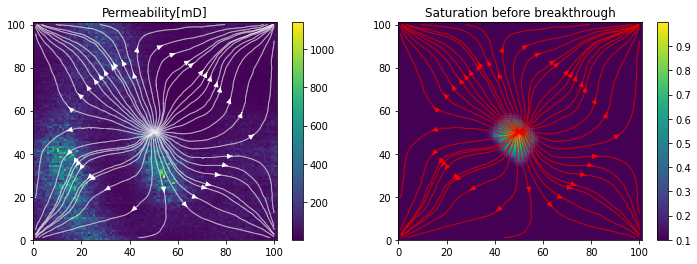

In [20]:
plt.figure(num=1, figsize=(12,4))
plt.subplot(121)
m.plot_streamline(p,m.permx,col='w')
plt.colorbar()
plt.title('Permeability[mD]')

plt.subplot(122)
m.plot_streamline(p,z,col='r')
plt.title('Saturation before breakthrough')
plt.colorbar()
plt.show()

#### Comparison after and before breaktrhough

<font color='red'>The differences between before and after the fluid reaches the production wells (breakthrough) is based on time (iterations). The pressure is constant before and after (not homogeneous) thus assuming incompressibility (if the model were compressible, then pressure would be affected by time as well). On the other hand, saturation depends on time and therefore the plots of the fluid flow is different before and after.
The streamlines give an insight of the flow rate: when the lines are long, the flow rate is slower than when the lines are small which indicates faster flow rates. Then, taking into account the direction of the permeability field (top left to bottom right), it makes sense that the streamlines are shorter in that direction indicating the faster flow of the fluid. At the same time this could be interpreted as a better conductivity between those two extremes.</font>

# 4. Change location of wells

In [37]:
class Model(DartsModel):
    def __init__(self, perm=None, nd = 60, db = 8):
        # call base class constructor
        super().__init__()

        # measure time spend on reading/initialization
        self.timer.node["initialization"].start()

        # create reservoir
        self.nx = nd
        self.ny = nd
        self.nz = 1
        
        self.dx = db
        self.dy = db
        self.dz = 4

        if (perm is None):
            perm = np.ones(self.nx*self.ny)*3000
        else:
            perm = perm.reshape(self.nx*self.ny)
            
        self.permx = perm
        self.permy = perm
        self.permz = 0.1 * perm
        self.poro = 0.2
        self.depth = 4000

        # run discretization
        self.reservoir = StructReservoir(self.timer, nx=self.nx, ny=self.ny, nz=self.nz, dx=self.dx, dy=self.dy,
                                         dz=self.dz, permx=self.permx, permy=self.permy, permz=self.permz,
                                         poro=self.poro, depth=self.depth)

        self.ix = np.int32(self.nx * 2/3)
        self.iy = np.int32(self.ny * 2/3)
        
        self.reservoir.add_well("INJ1")
        self.reservoir.add_perforation(self.reservoir.wells[-1], self.ix, self.iy, 1,  well_index=10)

        # Production wells
        self.reservoir.add_well("PRD1")
        self.reservoir.add_perforation(self.reservoir.wells[-1], np.int32(self.nx*(2/3)),self.ny, 1, well_index=10)
        
        self.reservoir.add_well("PRD2")
        self.reservoir.add_perforation(self.reservoir.wells[-1], np.int32(self.nx*(2/3)),1 , 1, well_index=10)
        
        self.reservoir.add_well("PRD3")
        self.reservoir.add_perforation(self.reservoir.wells[-1], 1, np.int32(self.ny*(2/3)), 1, well_index=10)
        
        self.reservoir.add_well("PRD4")
        self.reservoir.add_perforation(self.reservoir.wells[-1], self.nx, np.int32(self.ny*(2/3)), 1, well_index=10)
        
        
        # create physics
        self.physics = DeadOil(timer=self.timer, physics_filename='physics.in',
                               n_points=401, min_p=300, max_p=600, min_z=1e-8)

        self.params.first_ts = 1
        self.params.mult_ts = 2
        self.params.max_ts = 50
        self.params.tolerance_newton = 1e-2
        self.params.tolerance_linear = 1e-3

        self.inj = [1]

        self.runtime = 1000

        self.timer.node["initialization"].stop()

    def set_initial_conditions(self):
        self.physics.set_uniform_initial_conditions(self.reservoir.mesh, uniform_pressure=400,
                                                    uniform_composition=[0.1])

    def set_boundary_conditions(self):
        for i, w in enumerate(self.reservoir.wells):
            if w.name[:3] == "INJ":
                w.control = self.physics.new_bhp_water_inj(410, self.inj)
                # w.constraint = self.physics.new_rate_water_prod(210)
            else:
                w.control = self.physics.new_bhp_prod(390)

    # This function plots streamlines based on passed pressure solution 
    # and permebility map from model class
    def plot_streamline(self, p, array, col='r'):

        P_2D = p.reshape(self.nx, self.ny)
        kx = self.permx.reshape(self.ny, self.nx)
        ky = self.permy.reshape(self.ny, self.nx)
        nvx, nvy = (self.nx-1, self.ny-1)

        v = np.zeros((nvx, nvy))
        u = np.zeros((nvx, nvy))
        ir, jr = (range(nvx), range(nvy))

        for i in ir:
            v[i, jr] = (kx[i, jr] + kx[i + 1, jr]) * (P_2D[i, jr] - P_2D[i + 1, jr])
        for j in jr:
            u[ir, j] = (ky[ir, j] + ky[ir, j + 1]) * (P_2D[ir, j] - P_2D[ir, j + 1])

        # find circle in 2D index array with radius r
        x = np.arange(0, nvx)
        y = np.arange(0, nvy)
        arr = np.zeros((nvx,nvy))
        r = 6. # make sure that the model is larger than [2r] * [2r]
        arr[(x[np.newaxis, :] - self.ix) ** 2 + (y[:, np.newaxis] - self.iy) ** 2 < r ** 2] = 1
        arr[(x[np.newaxis, :] - self.ix) ** 2 + (y[:, np.newaxis] - self.iy) ** 2 < (r-1) ** 2] = 0

        # starting points for streamlines
        sp = np.array(np.where(arr == 1))
        y, x = np.mgrid[1:nvy+1, 1:nvx+1]
        cont = plt.streamplot(x, y, u, v, density=100, color=col, linewidth=1, cmap='autumn', start_points=sp.T)

        array=array.reshape(self.ny, self.nx)
        plt.pcolor(array)

In [38]:
# Call model with new changes
m = Model(perm, 101)
m.init()
m.run()
print("Simulation finished")

darts-package built on 08/10/2020 18:32:54 by root@runner-Gd7HMPkj-project-1205-concurrent-0 from 180bd2c
Building connection list...
Simulation finished


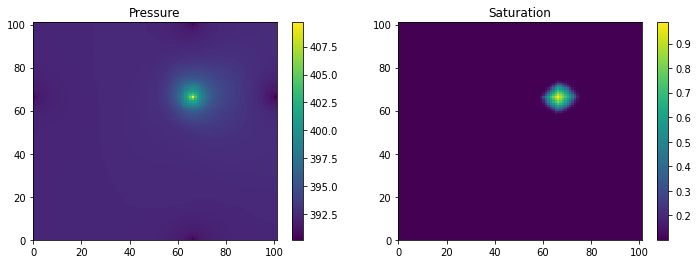

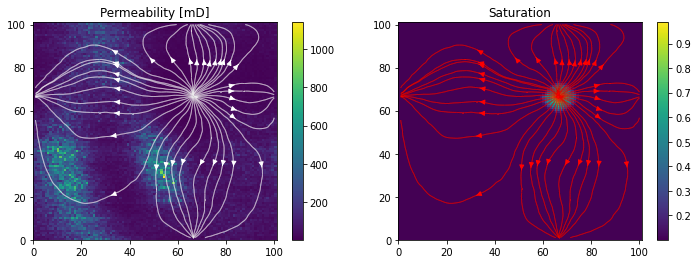

In [39]:
X  = np.array(m.physics.engine.X, copy=False)
nb = m.nx * m.ny

p  = X[0:2*nb:2] 
z  = X[1:2*nb:2] 

# plot solution
plt.figure(num=1, figsize=(12,4))
plt.subplot(121)
plt.pcolor(p.reshape(m.ny, m.nx))
plt.title('Pressure')
plt.colorbar()

# plot solution
plt.subplot(122)
plt.pcolor(z.reshape(m.ny, m.nx))
plt.title('Saturation')
plt.colorbar()
plt.show()

m.iy = m.nx*(2/3)
m.ix = m.ny*(2/3)
        
plt.figure(num=1, figsize=(12,4))
plt.subplot(121)
m.plot_streamline(p,m.permx,col='w')
plt.colorbar()
plt.title('Permeability [mD]')

plt.subplot(122)
m.plot_streamline(p,z,col='r')
plt.title('Saturation')
plt.colorbar()
plt.show()

<font color='red'>In this case the production wells near the injector have smaller streamlines due to the flow rate is greater that for produrtors far from the injecto. However, the low permeability does not make straight lines meaning a fast flow rate. At the bottom left, some streamlines can be seen following the high permebility fields.</font>